 # Libraries Installation

### OS Issues

In [35]:
# MacOS specific .dylib 
from pathlib import Path
import os
import platform

system_os = platform.system()

# Get current script directory
base_path = Path().resolve()

if system_os == "Darwin":  # macOS
    epanet_lib_path = base_path / "lib" / "libepanet.dylib"
    os.environ["EPANET_PATH"] = str(epanet_lib_path)

elif system_os == "Linux":
    epanet_lib_path = base_path / "lib" / "libepanet.so"
    os.environ["EPANET_PATH"] = str(epanet_lib_path)

elif system_os == "Windows":
    print("Windows detected. No need to set EPANET_PATH.")

else:
    raise EnvironmentError(f"Unsupported OS: {system_os}")



In [36]:
# Upgrade pip and install packages from requirements.txt (cross-platform safe)
%pip install --upgrade pip
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Genetic Algorithm

## Setting up Manual Functions

### Importing Libraries

In [37]:
import wntr
import numpy as np
from datetime import timedelta
import pandas as pd
import random
import copy
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

### Auxiliary Functions

In [38]:
# --- RESHAPE INDIVIDUAL TO SCHEDULE ---

def reshape_individual(individual, wntk):

    # Reshape the individual to a 2D array
    schedule = np.array(individual).reshape(wntk.describe(level=1)['Links']['Pumps'], (int(wntk.options.time.duration / wntk.options.time.hydraulic_timestep) + 1)).tolist()

    return schedule

In [39]:
# --- SCHEDULE ADDITION ---

def add_schedule(schedule, wntk):
    for i in range(wntk.describe(level=1)['Links']['Pumps']):
        for j in range(int(wntk.options.time.duration / wntk.options.time.hydraulic_timestep) + 1):
            pump = wntk.get_link(wntk.pump_name_list[i])
            condition = wntr.network.controls.SimTimeCondition(wntk, '=', str(timedelta(hours=j)))
            action = wntr.network.controls.ControlAction(pump, 'status', schedule[i][j])
            control = wntr.network.controls.Control(condition, action, name=f'Control_pump{i}_time{j}')
            wntk.add_control(f"Control Pump ID : {i}, Hour : {j}", control)

In [40]:
# --- ADDED SCHEDULE REMOVAL {EXCLUSIVELY THE ONES FROM ADD SCHEDULE}---

def remove_schedule(wntk):
    for i in range(wntk.describe(level=1)['Links']['Pumps']):
        for j in range(int(wntk.options.time.duration / wntk.options.time.hydraulic_timestep) + 1):
            wntk.remove_control(f"Control Pump ID : {i}, Hour : {j}")

In [41]:
# --- SWTICH COUNT FUNCTION ---

def count_switches(individual):
    """
    Counts the number of ON/OFF switches per pump for a single individual.

    Args:
        individual: list of lists; each inner list is a binary schedule (0 or 1) over time for one pump.

    Returns:
        List of integers: number of switches per pump.
    """
    switch_counts = []
    
    for schedule in individual:
        count = sum(schedule[i] != schedule[i - 1] for i in range(1, len(schedule)))
        switch_counts.append(count)
    
    return switch_counts



## Setting up DEAP framework

### Setting up Libraries

In [42]:
# Necessary Libraries for DEAP and Torch
from deap import base, tools, creator, algorithms

# --- CONFIGURATION ---
wn = wntr.network.WaterNetworkModel('Network Files/Net3.inp')
NUM_PUMPS = wn.describe(level=1)['Links']['Pumps']
NUM_TIMESTAMPS = (int(wn.options.time.duration / wn.options.time.hydraulic_timestep) + 1)
CHROM_SIZE = NUM_PUMPS * NUM_TIMESTAMPS  # No of Pumps * No of Timestamps

### Evaluation Function

In [43]:
# --- EVALUATION FUNCTION ---

def evaluation(individual, wntk = wn):

    wntk_copy = copy.deepcopy(wntk)

    # Reshape the individual to a schedule
    schedule = reshape_individual(individual, wntk_copy)

    # Get Total Number of Pump Switches
    switches_count = count_switches(schedule)

    for control_name in wntk_copy.control_name_list:
        wntk_copy.remove_control(control_name)

    # Add the schedule to the WNTR model
    add_schedule(schedule, wntk_copy)

    # Run the simulation
    sim = wntr.sim.WNTRSimulator(wntk_copy)
    results = sim.run_sim()

    # Reset the simulation
    remove_schedule(wntk_copy)
    wntk_copy.reset_initial_values()
    
    # --- Objectives ---

    # === Objective 1 - Total Cost of pump Operation ===

    gamma = 9.81
    timestep = wntk_copy.options.time.hydraulic_timestep
    duration_hr = timestep / 3600
    electricity_prices =[0.0244]*7+[0.1194]*15+[0.0244]*3
    pump_efficiency = 0.8

    total_pump_cost = 0
    num_price_steps = len(electricity_prices)
    max_power = 0

    for pump_name in wntk_copy.pump_name_list:
        pump = wntk_copy.get_link(pump_name)
        curve = wntk_copy.get_curve(pump.pump_curve_name)
        points = np.array(curve.points)
        flows = points[:, 0]
        heads = points[:, 1]

        pump_flows = results.link['flowrate'][pump_name].values

        for t, flow in enumerate(pump_flows[:num_price_steps]):
            if flow <= 0:
                continue

            head = np.interp(flow, flows, heads)
            power_kw = (gamma * head * flow) / (pump_efficiency)
            max_power = max(max_power, power_kw)

            cost = power_kw * electricity_prices[t] * duration_hr
            total_pump_cost += cost
    #print(f"Pump Flows : {pump_flows}")
    # === Objective 2 - Pump switch penalization ===
    cm = 5
    switch_penalty_cost = cm * sum(switches_count)

    # === Objective 3 - Cost of Demand Charges ===
    cd = 0.5
    demand_charge_cost = cd * max_power

    # --- Constraints ---

    constraint_penalty = 0

    # === Number of pump switches ===
    if any(switch > 5 for switch in switches_count):
        constraint_penalty += 1000000

    # === Tank Head constraints ===
    tank_min = 6
    tank_max = 60
    for tank_name in wntk_copy.tank_name_list:
        tank = wntk_copy.get_node(tank_name)
        min_level = tank_min
        max_level = tank_max
        tank_levels = results.node['head'][tank_name].values

        for t, level in enumerate(tank_levels):
            if level < min_level or level > max_level:
                constraint_penalty += 1000000
    
    # === Combined water volume constraints ===
    D_min = -10  # Minimum percentage difference (e.g., -10%)
    D_max = 10   # Maximum percentage difference (e.g., 10%)

    # Calculate Vs (sum of tank volumes at the start of the schedule)
    Vs = sum([wntk_copy.get_node(tank_name).init_level for tank_name in wntk.tank_name_list])

    # Calculate Ve (sum of tank volumes at the end of the schedule)
    Ve = sum([results.node['head'][tank_name].iloc[-1] for tank_name in wntk.tank_name_list])

    # Calculate percentage difference
    if Ve != 0:  # Avoid division by zero
        D = ((Vs - Ve) / Ve) * 100
        if D < D_min or D > D_max:
            constraint_penalty += 1000000  # Add a large penalty if the constraint is violated


    return total_pump_cost + switch_penalty_cost + demand_charge_cost + constraint_penalty,

In [44]:
# --- CREATE TYPES ---

# Assigning Mult-Class Fitness Weigths
creator.create("FitnessMulti", base.Fitness, weights=(-1.0,))

# Defining Individual
creator.create("Individual", list, fitness = creator.FitnessMulti)

toolbox = base.Toolbox()

# --- CREATE TOOLS ---

# Define Binary Genes
toolbox.register("attr_bool", random.randint, 0, 1)

# Define Individual (List of Binary Values)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=CHROM_SIZE)

# Define Random Population
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Register the Fitness function
toolbox.register("evaluate", evaluation)

# Define Selection Methodology
toolbox.register("select", tools.selTournament, tournsize = 20)

# Define Crossover Methodology
toolbox.register("mate", tools.cxTwoPoint)

# Define Mutation Methodology
toolbox.register("mutate", tools.mutFlipBit, indpb = 0.1)

# Set Hall of Fame
hof = tools.HallOfFame(10)

/Users/meherdasu/Documents/Git-Hub_Projects/Water-Network-Pump-Scheduling-Optimization/.venv/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/meherdasu/Documents/Git-Hub_Projects/Water-Network-Pump-Scheduling-Optimization/.venv/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [45]:
import os
from datetime import datetime

# --- GENETIC ALGO LOOP WITH RESULTS SAVING ---
def run_ga(pop_size=40, generations=50, cx_prob=0.7, mut_prob=0.3):
    # Create population
    population = toolbox.population(n=pop_size)

    # Objective Statistics
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    stats.register("max", np.max)

    # Run the Genetic Algorithm
    population, logbook = algorithms.eaSimple(
        population=population,
        toolbox=toolbox,
        cxpb=cx_prob,
        mutpb=mut_prob,
        ngen=generations,
        stats=stats,
        halloffame=hof,
        verbose=True,
    )

    # Get the best individual
    best_ind = hof[0]
    best_fitness = best_ind.fitness.values

    # Generate a timestamp
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

    # Create a results directory if it doesn't exist
    results_dir = "Run_Results"
    os.makedirs(results_dir, exist_ok=True)

    # Write results to a file
    results_file = os.path.join(results_dir, f"GA_Run_{timestamp}.txt")
    with open(results_file, "w") as f:
        f.write(f"Timestamp: {timestamp}\n")
        f.write(f"Population Size: {pop_size}\n")
        f.write(f"Generations: {generations}\n")
        f.write(f"Crossover Probability: {cx_prob}\n")
        f.write(f"Mutation Probability: {mut_prob}\n\n")
        f.write(f"Best Individual: {best_ind}\n")
        f.write(f"Fitness: {best_fitness}\n\n")
        f.write("Logbook:\n")
        for record in logbook:
            f.write(f"{record}\n")

    print(f"Results saved to {results_file}")

    return best_ind, logbook, population, hof


In [ ]:
best_sol, logbook, population, hof = run_ga(5, 5)

# Plot Functions

[[1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0], [0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1]]


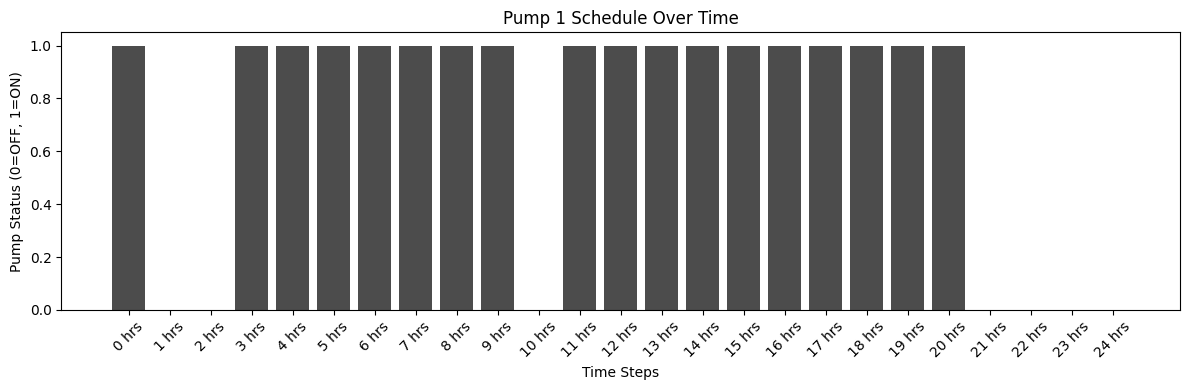

In [167]:
import matplotlib.pyplot as plt
import wntr

wn = wntr.network.WaterNetworkModel('Network Files/Net3.inp')

solution = [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1]
#solution = [1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1]
print(reshape_individual(solution, wn))

original_schedule = reshape_individual(solution, wn)

for control_name in wn.control_name_list:
        wn.remove_control(control_name)

add_schedule(original_schedule, wn)
sim = wntr.sim.WNTRSimulator(wn)
results = sim.run_sim()

new_solution = np.reshape(np.array(results.link['status'][wn.pump_name_list]).T,(1,-1))
schedule = reshape_individual(new_solution, wn)

# Plot schedule against time as a histogram for Pump 1
plt.figure(figsize=(12, 4))
plt.bar(range(len(schedule[0])), schedule[0], color='black', alpha=0.7)
plt.title('Pump 1 Schedule Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Pump Status (0=OFF, 1=ON)')
plt.xticks(range(len(schedule[0])), [f'{i} hrs' for i in range(len(schedule[0]))], rotation=45)
plt.tight_layout()
plt.show()

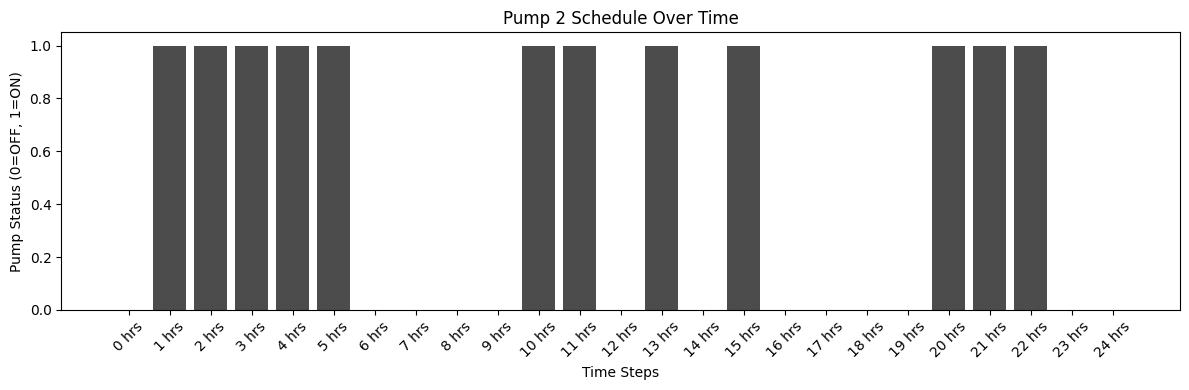

In [168]:
# Plot schedule against time as a histogram for Pump 2
plt.figure(figsize=(12, 4))
plt.bar(range(len(schedule[1])), schedule[1], color='black', alpha=0.7)
plt.title('Pump 2 Schedule Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Pump Status (0=OFF, 1=ON)')
plt.xticks(range(len(schedule[1])), [f'{i} hrs' for i in range(len(schedule[1]))], rotation=45)
plt.tight_layout()
plt.show()

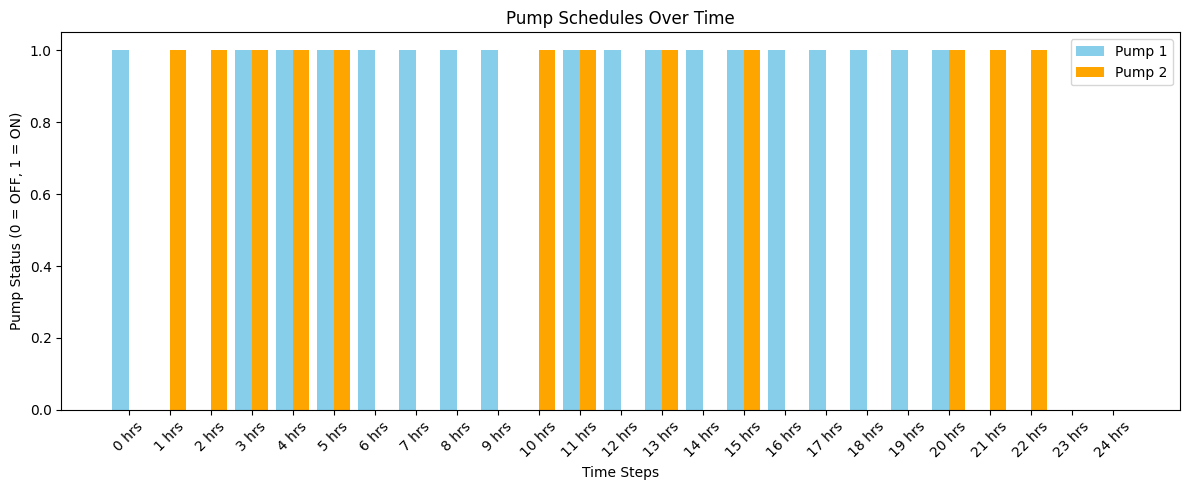

In [169]:
plt.figure(figsize=(12, 5))

time_steps = np.arange(len(schedule[0]))
bar_width = 0.4

# Shift Pump 1 left and Pump 2 right to avoid overlap
plt.bar(time_steps - bar_width/2, schedule[0], width=bar_width, label='Pump 1', color='skyblue')
plt.bar(time_steps + bar_width/2, schedule[1], width=bar_width, label='Pump 2', color='orange')

plt.title('Pump Schedules Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Pump Status (0 = OFF, 1 = ON)')
plt.xticks(time_steps, [f'{i} hrs' for i in time_steps], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


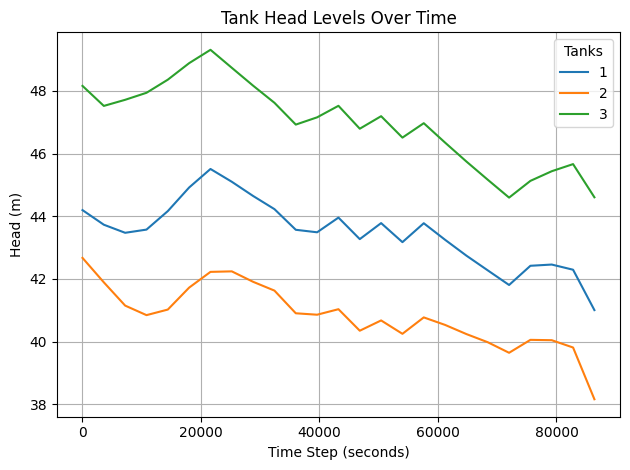

In [170]:
import matplotlib.pyplot as plt

results.node['head'][wn.tank_name_list].plot()
plt.title('Tank Head Levels Over Time')
plt.xlabel('Time Step (seconds)')
plt.ylabel('Head (m)')
plt.legend(title='Tanks')
plt.grid(True)
plt.tight_layout()
plt.show()


In [171]:
import numpy as np
import pandas as pd

gamma = 9.81  # gravitational constant
timestep = wn.options.time.hydraulic_timestep
duration_hr = timestep / 3600.0  # seconds to hours
electricity_prices = [0.0244]*7 + [0.1194]*15 + [0.0244]*3  # 25 time steps
pump_efficiency = 0.8

# Initialize storage
pump_names = wn.pump_name_list
num_steps = len(electricity_prices)
power_matrix = pd.DataFrame(0.0, index=range(num_steps), columns=pump_names)
cost_matrix = pd.DataFrame(0.0, index=range(num_steps), columns=pump_names)

max_power = 0
total_cost = 0

for pump_name in pump_names:
    pump = wn.get_link(pump_name)
    curve = wn.get_curve(pump.pump_curve_name)
    points = np.array(curve.points)
    flows = points[:, 0]
    heads = points[:, 1]

    pump_flows = results.link['flowrate'][pump_name].values

    for t in range(min(num_steps, len(pump_flows))):
        flow = pump_flows[t]
        if flow <= 0:
            continue

        head = np.interp(flow, flows, heads)
        power_kw = (gamma * head * flow) / pump_efficiency  # kW
        power_matrix.loc[t, pump_name] = power_kw

        cost = power_kw * electricity_prices[t] * duration_hr
        cost_matrix.loc[t, pump_name] = cost

        max_power = max(max_power, power_kw)
        total_cost += cost

#print(f"Total energy cost: ${total_cost:.2f}")
#print(f"Maximum power observed: {max_power:.2f} kW")
#print(f"Power Matrix : {power_matrix}")
#print(f"Cost Matrix : {cost_matrix}")




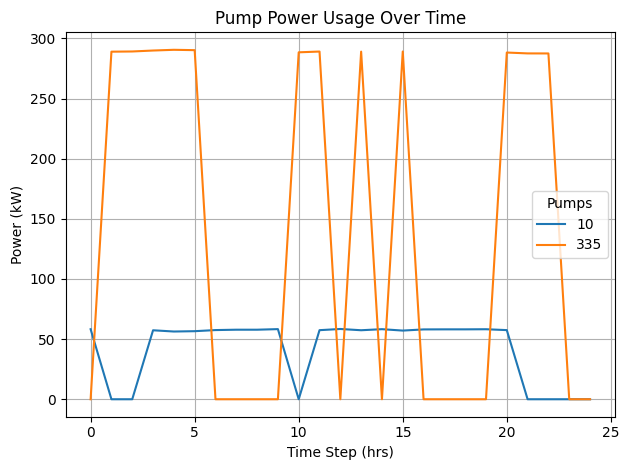

In [172]:
power_matrix.plot()
plt.title("Pump Power Usage Over Time")
plt.xlabel("Time Step (hrs)")
plt.ylabel("Power (kW)")
plt.grid(True)
plt.legend(title="Pumps")
plt.tight_layout()
plt.show()


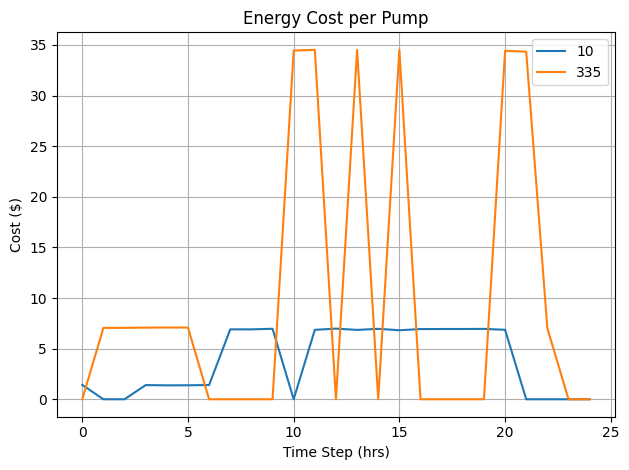

In [173]:
cost_matrix.plot()
plt.title("Energy Cost per Pump")
plt.ylabel("Cost ($)")
plt.xlabel("Time Step (hrs)")
plt.grid(True)
plt.tight_layout()
plt.show()


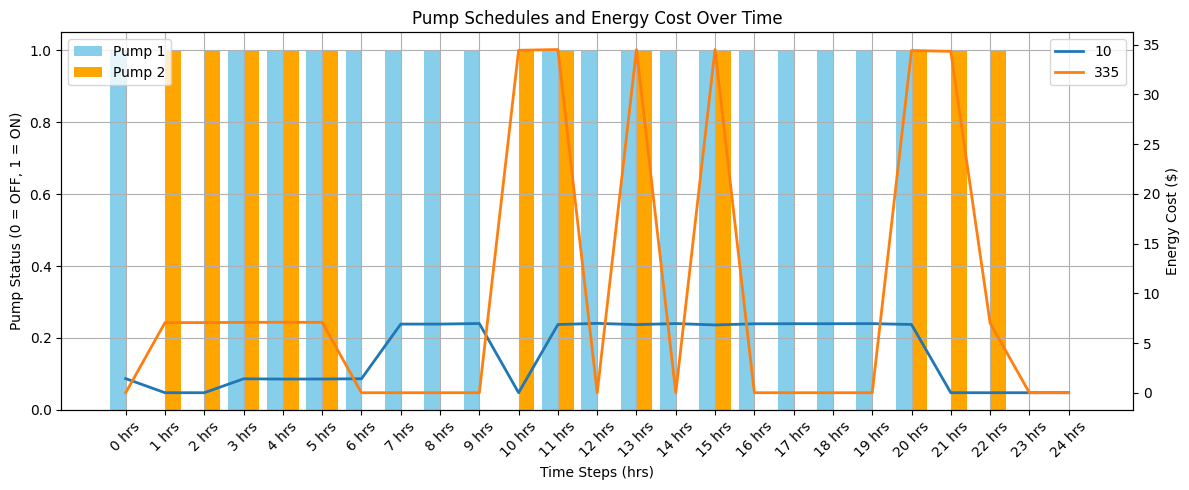

In [174]:
import matplotlib.pyplot as plt
import wntr

'''
# Load network
wn = wntr.network.WaterNetworkModel('Network Files/Net3.inp')

# Assuming best_sol and reshape_individual are already defined
solution = best_sol
schedule = reshape_individual(solution, wn)

# Add schedule to network (if needed for simulation)
add_schedule(schedule, wn)
'''

# Prepare time axis
time_steps = range(len(schedule[0]))
bar_width = 0.4

fig, ax1 = plt.subplots(figsize=(12, 5))

# Plot Pump Schedules (side-by-side bars)
ax1.bar(
    [t - bar_width / 2 for t in time_steps],
    schedule[0],
    width=bar_width,
    label='Pump 1',
    color='skyblue'
)
ax1.bar(
    [t + bar_width / 2 for t in time_steps],
    schedule[1],
    width=bar_width,
    label='Pump 2',
    color='orange'
)

ax1.set_xlabel('Time Steps (hrs)')
ax1.set_ylabel('Pump Status (0 = OFF, 1 = ON)')
ax1.set_xticks(time_steps)
ax1.set_xticklabels([f'{i} hrs' for i in time_steps], rotation=45)
ax1.legend(loc='upper left')
ax1.grid(True)

# Plot Energy Cost on Secondary Y-axis
ax2 = ax1.twinx()
cost_matrix.plot(ax=ax2, label='Energy Cost', linewidth=2)
ax2.set_ylabel('Energy Cost ($)')
ax2.legend(loc='upper right')

plt.title('Pump Schedules and Energy Cost Over Time')
plt.tight_layout()
plt.show()


# Notes for Report

- all issues on water networks on quality etc
- Issues in major cities
- About parameters of WN
- Elevation etc
- Connect with SGS goals
- SDG 6
* More on recent implementations of GA wrap up MNILP quickly
* Why transition
* encoding method change
* Compare Epanet and wntr
* Overlap cost and schedule plots
* Flow chart for Genetic Algorithm
* Citations and references to sources

Contents of Abstract

* Purpose

    The project focuses on optimizing operational cost of water distribution networks by modifying pump operation schedules while simultaneously meeting the water demand requirments and other constraints in the network.   

* Methods 

    An initial attempt was made to approach this problem by explicitly programming all the objectives and constraints as a Mixed Integer - Non Linear Programming Problem. But given the complexity of water network models, especially for those on a real scale, there is a huge scope for infeasiblities of constraints which also makes it difficult to trace out the source of any issue. This becomes a very challenging problem in terms of scaling it to larger networks both in terms of computational complexity and constraint infeasibility handling as it would be less resilient to unexpected parameter changes.

    Hence we had to come up with a strategy that is resilient to such situations by leveraging existing water distribution network simulators like EPANET and WNTR. These simulators are better at handling the necessary constraints and are better at handling unforeseen circumstances in constrast to explicitly programming it. The optimization problem is handled by Genetic algorithm while using the simulator to evaluate fitness.

* Results 

* Conclusions

-- Chapter 1 : Introduction

- 1.1 Background

* A water distribution network is a system of pipes, storage tanks, pumps and valves that deliver water from a treatment plant or source to consumers. It is important to maintain proper water distribution networks in cities and towns to be able to supply water in a safe and reliable manner.

* The design of water distribution network is heavily dependent on the elevation map of the terrain, locations of demand, location of water body sources and their relative elevation etc. A well designed water network should take into account a variety of details including minimal energy loss, leveraging elevation of sources to fulfill demand, preventing stagnation of water to avoid contamination etc. 

* Inadequate coverage, sporadic supplies, low pressure, and sub-standard quality are some of the most noticeable drawbacks in the water supply in Indian cities.
The problems range from “poor management of water sources, contaminated supplies, leaky distribution networks and vast volumes of untreated wastewater being poured into India's rivers.” Chennai's reservoirs became empty in the summer of 2019, prompting the government to truck in 10 million litres of water per day. This was remarkable for a city with an annual average rainfall of 1,400 mm, more than double what London receives.[cite-https://www.indiatoday.in/magazine/nation/story/20210329-the-cities-of-woe-1781275-2021-03-20] Water delivery in Indian cities is becoming increasingly difficult due to the city's continued growth and high urban population growth. These challenges impact the availability, quality, and sustainability of water resources. Uneven distribution of water resources
(Neeraj Singh Manhas, The Water Diplomat, 2023) across different regions of the country leads to disparities in water availability.[cite-https://www.indiawaterportal.org/health-and-sanitation/urban-sanitation/what-are-major-challenges-facing-urban-drinking-water-supply-india]

* 
